In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from tqdm import tqdm
import datetime

from keras.layers import BatchNormalization, Dropout, LSTM, Dense, Flatten, MaxPooling1D
from keras.layers import ConvLSTM2D, Input, Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD

from keras.layers import Flatten, MaxPooling1D

from keras.callbacks import EarlyStopping


import tensorflow as tf


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Historical_Wildfires.csv
For now, I will isolate the y_target, 'Estimated_fire_area' in order to see how many missing values we have on our dependant variable.

In [31]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']
# regions = ['QL']

merge_df = pd.DataFrame(index = range(5783))

for each in regions:
    df = pd.read_csv('{}_iso.csv'.format(each))
    df.drop(columns = ['Date'], inplace=True)

                        
#     for i in df.columns:
#         df[i] = df[i].fillna(method='ffill')
    
    merge_df = pd.concat([merge_df, df], axis = 1)


In [32]:
merge_df

,Estimated_fire_area_NSW,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,mean_SoilWaterContent_NSW,mean_SolarRadiation_NSW,mean_Temperature_NSW,mean_WindSpeed_NSW,Vegetation_index_mean_NSW,Estimated_fire_area_NT,...,Vegetation_index_mean_VI,Estimated_fire_area_WA,Count_WA,mean_Precipitation_WA,mean_RelativeHumidity_WA,mean_SoilWaterContent_WA,mean_SolarRadiation_WA,mean_Temperature_WA,mean_WindSpeed_WA,Vegetation_index_mean_WA
0,0.00000,0.0,0.044274,36.355567,0.170931,26.749389,27.341182,3.323550,0.348099,4.945,...,0.483291,36.382500,16.0,1.872415,49.027855,0.075728,26.967495,28.524055,4.201039,0.213268
1,0.00000,0.0,0.173879,38.699607,0.169551,27.047523,26.143898,3.030897,0.347922,1.320,...,0.482136,148.106471,34.0,2.110536,45.840524,0.079449,26.776612,28.695349,4.650767,0.213778
2,0.00000,0.0,3.011912,49.365152,0.179981,24.197452,27.408810,3.958409,0.347792,88.740,...,0.481227,60.632258,31.0,0.851700,39.740976,0.076233,28.656122,27.650498,5.216546,0.214268
3,8.68000,3.0,2.808620,57.095628,0.214293,22.617291,23.055527,4.841764,0.347685,0.000,...,0.480377,86.374167,36.0,0.155206,36.538677,0.067969,29.868001,27.421797,4.850140,0.214751
4,16.61125,8.0,0.157935,47.170735,0.203951,28.076835,22.425765,4.014080,0.347613,0.000,...,0.479711,31.378947,19.0,0.061034,33.564562,0.061579,30.280623,28.159704,4.464719,0.215187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.389724,NaN,...,0.441947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.215068
5862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.390272,NaN,...,0.442210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.215443
5863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.390813,NaN,...,0.442466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.215799
5864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.391353,NaN,...,0.442681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.216177


In [33]:
merge_df = merge_df.iloc[:5853, :].copy(deep=True)

In [34]:
fire_regions = ['Estimated_fire_area_{}'.format(i) for i in regions]
count_regions = ['Count_{}'.format(i) for i in regions]
sqrt_fire_regions = ['sqrt_{}'.format(i) for i in fire_regions]
sqrt_count_regions = ['sqrt_Count_{}'.format(i) for i in regions]

for i,x in zip(fire_regions, count_regions):
    merge_df[i] = np.log1p(merge_df[i])
    merge_df[x] = np.log1p(merge_df[i])
    
merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)
merge_df['Date'] = pd.date_range(start = '2005-01-01', end = '2021-01-09')
merge_df.set_index('Date', inplace=True)

for i,x in zip(fire_regions, count_regions):
    merge_df['sqrt_{}'.format(i)] = np.sqrt(merge_df[i])
    merge_df['sqrt_{}'.format(x)] = np.sqrt(merge_df[i]/merge_df[x]) * merge_df[x]
    
# merge_df.fillna(0, inplace=True)



In [35]:
merge_df.fillna(0, inplace=True)

In [36]:
merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)

In [37]:
merge_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.000000,1.782551,3.684660,0.000000,0.000000,0.000000,3.621203,0.000000,0.044274,36.355567,...,1.919547,2.385413,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.902946,2.354318
2005-01-02,0.000000,0.841567,4.181505,0.000000,0.000000,1.335001,5.004661,0.000000,0.173879,38.699607,...,2.044873,2.622780,0.000000,0.000000,0.00000,0.000000,1.155422,1.064001,2.237110,2.995168
2005-01-03,0.000000,4.496917,3.879223,0.000000,0.000000,0.693147,4.121185,0.000000,3.011912,49.365152,...,1.969574,2.479620,0.000000,0.000000,0.00000,0.000000,0.832555,0.604155,2.030070,2.594511
2005-01-04,2.270062,0.000000,3.437208,0.000000,0.000000,0.000000,4.470200,1.184809,2.808620,57.095628,...,1.853971,2.263079,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.114285,2.756135
2005-01-05,2.868538,0.000000,1.609438,0.000000,0.000000,0.000000,3.477508,1.352877,0.157935,47.170735,...,1.268636,1.242444,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.864808,2.283203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-05,0.000000,0.000000,1.124930,0.000000,0.000000,0.000000,3.561677,0.000000,0.827640,57.704412,...,1.060627,0.920816,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.887241,2.324978
2021-01-06,0.000000,0.000000,2.743534,0.000000,0.000000,0.000000,3.304980,0.000000,3.579036,60.555969,...,1.656362,1.903037,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.817960,2.196479
2021-01-07,0.841567,0.000000,0.000000,0.000000,0.000000,0.000000,2.938500,0.610617,1.188124,57.479931,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.714205,2.007012


In [38]:
train = merge_df[:'2020-12-01']
test = merge_df['2020-12-01':]

In [39]:
test.shape

(40, 77)

In [40]:

tf.keras.backend.clear_session()

In [41]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(train)
_train = scaler.transform(train)
_train.shape

(5814, 77)

In [42]:

def split_sequence(sequences, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(0, len(sequences), 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix, :]
        seq_y = sequences[end_ix:out_end_ix, :7]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [43]:
n_steps_in, n_steps_out = 120, 20

In [44]:
X, y = split_sequence(_train, n_steps_in, n_steps_out)
y.shape

(5675, 20, 7)

In [45]:
X.shape

(5675, 120, 77)

In [46]:
# from sklearn.utils import shuffle
# X, y = shuffle(X, y)

In [47]:
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
n_features = X.shape[2]

In [48]:
y.shape

(5675, 140)

In [49]:
n_output

140

In [50]:
X_train, y_train = X[:-365,:,:], y[:-365,:]
X_valid, y_valid = X[-365:, :, :], y[-365:, :]

In [25]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)

    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)
pred_seq_train = Dense(n_output, activation = 'relu')(out)

model = Model(history_seq, pred_seq_train)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr = 1e-6)

model.compile(optimizer, loss= tf.keras.losses.Poisson(), metrics = ['mae'])

In [53]:
history = model.fit(X_train, y_train, epochs = 100, callbacks = [lr_schedule], validation_data = (X_valid, y_valid))

Epoch 1/100
167/167 [==============================] - 13s 80ms/step - loss: 2.6321 - mae: 0.2654 - val_loss: 2.3586 - val_mae: 0.2440
Epoch 2/100
167/167 [==============================] - 12s 72ms/step - loss: 2.6231 - mae: 0.2646 - val_loss: 2.3531 - val_mae: 0.2432
Epoch 3/100
167/167 [==============================] - 12s 70ms/step - loss: 2.6178 - mae: 0.2636 - val_loss: 2.3490 - val_mae: 0.2424
Epoch 4/100
167/167 [==============================] - 12s 70ms/step - loss: 2.6102 - mae: 0.2626 - val_loss: 2.3451 - val_mae: 0.2416
Epoch 5/100
167/167 [==============================] - 12s 70ms/step - loss: 2.6038 - mae: 0.2616 - val_loss: 2.3403 - val_mae: 0.2407
Epoch 6/100
167/167 [==============================] - 12s 71ms/step - loss: 2.5974 - mae: 0.2605 - val_loss: 2.3355 - val_mae: 0.2396
Epoch 7/100
167/167 [==============================] - 12s 70ms/step - loss: 2.5906 - mae: 0.2592 - val_loss: 2.3313 - val_mae: 0.2385
Epoch 8/100
167/167 [==============================] - 

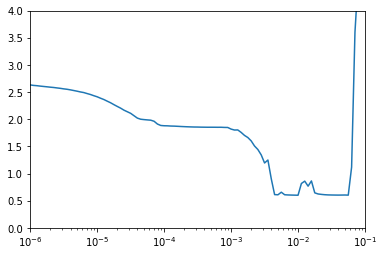

In [56]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 4]);

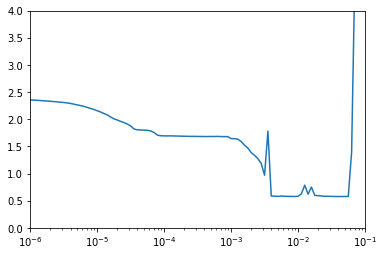

In [57]:
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e-1, 0, 4]);

In [51]:

n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2

tf.keras.backend.clear_session()
# history_seq = Input(shape =(n_steps_in, n_features))
history_seq = Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    
    # residual connection
    x = Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))


# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)

out = Conv1D(1, 1, padding='same')(out)
out = Flatten()(out)


pred_seq_train = Dense(n_output, activation = 'relu')(out)
model = Model(history_seq, pred_seq_train)


optimizer = tf.keras.optimizers.Adam(lr = 1e-4
                                    )

# tf.keras.losses.Poisson()
model.compile(optimizer, loss=tf.keras.losses.Poisson(), metrics = ['mae'])

In [61]:
history = model.fit(X_train, y_train, epochs = 200, validation_data = (X_valid, y_valid))

Epoch 1/200
166/166 [==============================] - 13s 76ms/step - loss: 0.7021 - mae: 0.1176 - val_loss: 0.6730 - val_mae: 0.1422
Epoch 2/200
166/166 [==============================] - 13s 79ms/step - loss: 0.7021 - mae: 0.1179 - val_loss: 0.6740 - val_mae: 0.1431
Epoch 3/200
166/166 [==============================] - 12s 74ms/step - loss: 0.7019 - mae: 0.1172 - val_loss: 0.6745 - val_mae: 0.1447
Epoch 4/200
166/166 [==============================] - 12s 74ms/step - loss: 0.7021 - mae: 0.1178 - val_loss: 0.6733 - val_mae: 0.1402
Epoch 5/200
166/166 [==============================] - 12s 75ms/step - loss: 0.7017 - mae: 0.1170 - val_loss: 0.6725 - val_mae: 0.1400
Epoch 6/200
166/166 [==============================] - 13s 77ms/step - loss: 0.7015 - mae: 0.1168 - val_loss: 0.6752 - val_mae: 0.1462
Epoch 7/200
166/166 [==============================] - 12s 73ms/step - loss: 0.7038 - mae: 0.1203 - val_loss: 0.6724 - val_mae: 0.1416
Epoch 8/200
166/166 [==============================] - 

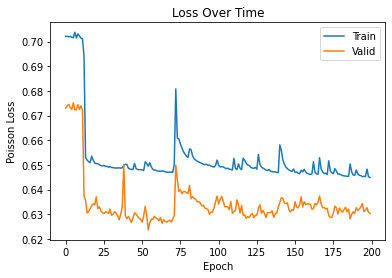

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [63]:
x_input = np.array(train.iloc[-120:].values)
x_input = scaler.transform(x_input)

x_input = x_input.reshape((1, n_steps_in, n_features))

yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 140)

In [64]:
yhat_df = pd.DataFrame(yhat.reshape(20,7), index = test[:20].index, columns = fire_regions)

In [65]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
Date,,,,,,,
2020-12-01,0.184001,0.310032,0.556098,0.103694,0.075290,0.086822,0.516444
2020-12-02,0.209155,0.279842,0.547675,0.129511,0.083376,0.073230,0.517947
2020-12-03,0.209366,0.275396,0.547125,0.132216,0.070429,0.081996,0.502299
2020-12-04,0.200813,0.261976,0.548695,0.112436,0.055780,0.095026,0.487395
2020-12-05,0.207789,0.236138,0.536081,0.000000,0.068502,0.099137,0.473092
2020-12-06,0.196828,0.229208,0.541742,0.113662,0.085775,0.091309,0.469239
2020-12-07,0.202604,0.239256,0.526475,0.000000,0.000000,0.058071,0.460702
2020-12-08,0.217705,0.213733,0.526603,0.118728,0.000000,0.082606,0.454685
2020-12-09,0.218106,0.205700,0.507661,0.144928,0.000000,0.083124,0.454952


In [66]:
for i in range(70):
    yhat_df['dummy_{}'.format(i)] = 0
    
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

In [67]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,dummy_0,dummy_1,dummy_2,...,dummy_60,dummy_61,dummy_62,dummy_63,dummy_64,dummy_65,dummy_66,dummy_67,dummy_68,dummy_69
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,1.573845,2.859259,4.598174,0.768783,0.505947,0.695210,4.669784,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-02,1.788997,2.580827,4.528531,0.960185,0.560283,0.586377,4.683378,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-03,1.790809,2.539833,4.523984,0.980244,0.473280,0.656573,4.541883,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-04,1.717644,2.416062,4.536968,0.833591,0.374837,0.760908,4.407115,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-05,1.777316,2.177770,4.432662,0.000000,0.460329,0.793824,4.277787,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-06,1.683558,2.113863,4.479475,0.842685,0.576406,0.731141,4.242948,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-07,1.732970,2.206531,4.353233,0.000000,0.000000,0.464990,4.165753,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-08,1.862137,1.971147,4.354295,0.880246,0.000000,0.661453,4.111350,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-09,1.865563,1.897061,4.197667,1.074484,0.000000,0.665600,4.113766,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
test[:20]

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,0.000000,3.952441,5.482567,0.0,0.000000,0.000000,2.940440,0.000000,0.206143,39.675256,...,2.341488,3.201181,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.714771,2.008034
2020-12-02,0.000000,3.344980,5.793518,0.0,0.000000,0.000000,4.767425,0.000000,1.029015,42.126130,...,2.406973,3.331697,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.183443,2.890260
2020-12-03,1.071584,0.741937,5.230254,0.0,0.000000,0.000000,3.305879,0.728313,2.246048,46.104476,...,2.286975,3.093269,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.818208,2.196935
2020-12-04,1.798404,2.091041,6.379596,0.0,0.000000,1.526056,2.840247,1.029049,0.425724,35.201274,...,2.525786,3.570857,0.0,0.0,0.000000,0.000000,1.235337,1.189174,1.685303,1.954906
2020-12-05,0.693147,2.325325,6.154903,0.0,0.000000,0.000000,3.068983,0.526589,5.091297,61.585253,...,2.480908,3.480173,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.751851,2.075329
2020-12-06,0.000000,3.091529,6.331382,0.0,0.000000,0.000000,3.074117,0.000000,0.224302,43.849043,...,2.516224,3.551500,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.753316,2.077997
2020-12-07,1.321756,2.398804,5.910069,0.0,0.000000,0.000000,3.444595,0.842324,0.667009,47.497153,...,2.431063,3.379947,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.855962,2.266774
2020-12-08,3.069912,3.806151,6.018555,0.0,0.000000,0.000000,1.945910,1.403621,0.012537,42.210711,...,2.453274,3.424544,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.394959,1.449964
2020-12-09,1.996060,3.227637,5.620567,0.0,0.000000,0.000000,1.098612,1.097298,0.034324,39.774069,...,2.370773,3.259431,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.048147,0.902427


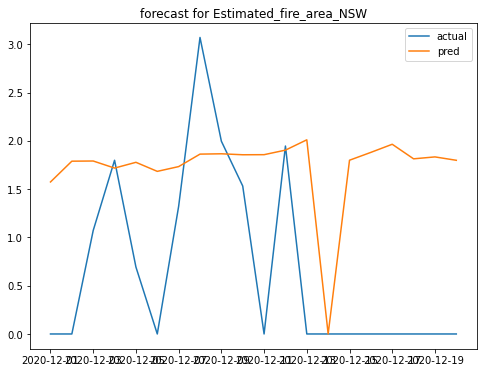

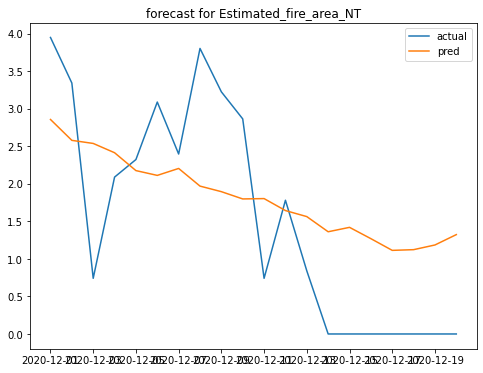

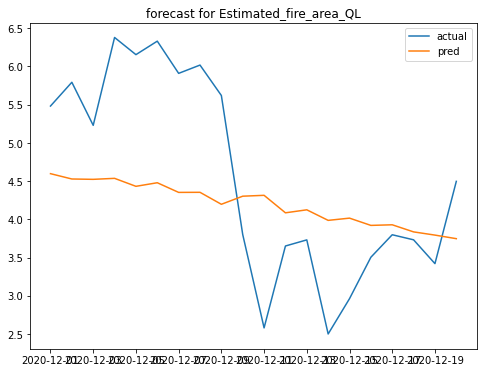

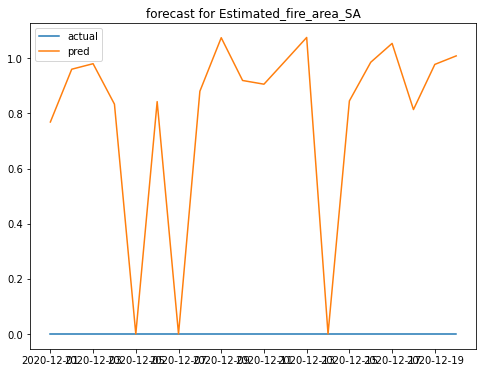

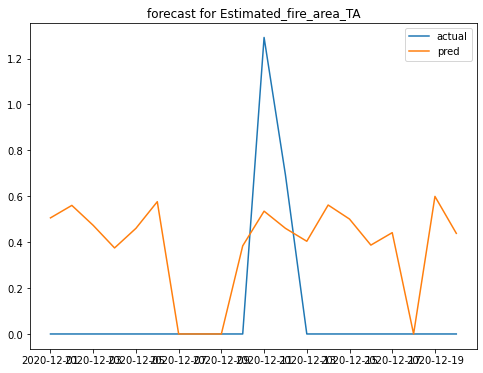

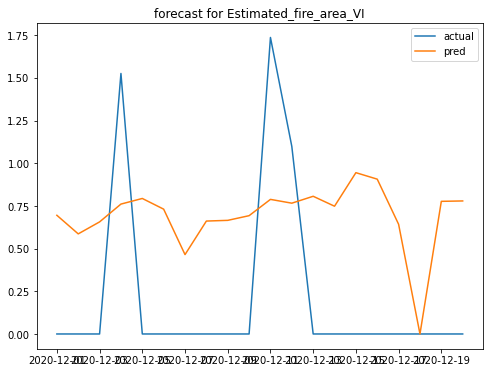

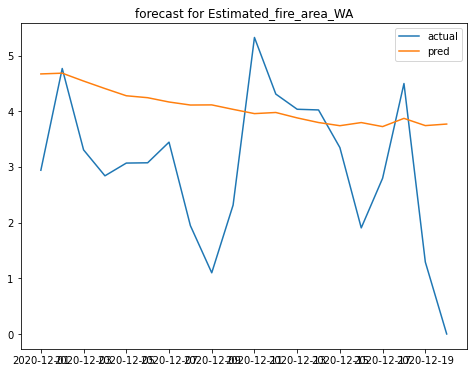

In [69]:
for i in fire_regions:

    plt.figure(figsize=(8,6))
    plt.plot(test[:20][i], label = 'actual')
    plt.plot(yhat_df[i], label ='pred')
    plt.title('forecast for {}'.format(i))
    plt.legend()
    plt.show();

In [76]:
merge_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.000000,1.782551,3.684660,0.000000,0.000000,0.000000,3.621203,0.000000,0.044274,36.355567,...,1.919547,2.385413,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.902946,2.354318
2005-01-02,0.000000,0.841567,4.181505,0.000000,0.000000,1.335001,5.004661,0.000000,0.173879,38.699607,...,2.044873,2.622780,0.000000,0.000000,0.00000,0.000000,1.155422,1.064001,2.237110,2.995168
2005-01-03,0.000000,4.496917,3.879223,0.000000,0.000000,0.693147,4.121185,0.000000,3.011912,49.365152,...,1.969574,2.479620,0.000000,0.000000,0.00000,0.000000,0.832555,0.604155,2.030070,2.594511
2005-01-04,2.270062,0.000000,3.437208,0.000000,0.000000,0.000000,4.470200,1.184809,2.808620,57.095628,...,1.853971,2.263079,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.114285,2.756135
2005-01-05,2.868538,0.000000,1.609438,0.000000,0.000000,0.000000,3.477508,1.352877,0.157935,47.170735,...,1.268636,1.242444,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.864808,2.283203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-05,0.000000,0.000000,1.124930,0.000000,0.000000,0.000000,3.561677,0.000000,0.827640,57.704412,...,1.060627,0.920816,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.887241,2.324978
2021-01-06,0.000000,0.000000,2.743534,0.000000,0.000000,0.000000,3.304980,0.000000,3.579036,60.555969,...,1.656362,1.903037,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.817960,2.196479
2021-01-07,0.841567,0.000000,0.000000,0.000000,0.000000,0.000000,2.938500,0.610617,1.188124,57.479931,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.714205,2.007012


In [93]:
x_input = np.array(merge_df.iloc[-120:].values)
x_input = scaler.transform(x_input)

x_input = x_input.reshape((1, n_steps_in, n_features))

yhat = model.predict(x_input, verbose=0)
yhat.shape

(1, 140)

In [94]:
yhat_df = pd.DataFrame(yhat.reshape(20,7), index = pd.date_range(start = '2021-01-10', end = '2021-01-29'), columns = fire_regions)

In [95]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
2021-01-10,0.145575,0.305999,0.470346,0.125685,0.092377,0.141347,0.471676
2021-01-11,0.135315,0.302877,0.479657,0.115311,0.091857,0.139515,0.473447
2021-01-12,0.139363,0.300471,0.470044,0.115138,0.099162,0.135540,0.465328
2021-01-13,0.129977,0.284866,0.463829,0.107577,0.086775,0.121807,0.457008
2021-01-14,0.115315,0.277654,0.448826,0.000000,0.094107,0.115238,0.455645
2021-01-15,0.120313,0.274906,0.459647,0.096344,0.104521,0.098057,0.437492
2021-01-16,0.111394,0.260320,0.445345,0.000000,0.000000,0.104174,0.435067
2021-01-17,0.113062,0.248786,0.451948,0.091456,0.000000,0.102835,0.408029
2021-01-18,0.122701,0.242987,0.429173,0.091535,0.000000,0.092636,0.423001
2021-01-19,0.104735,0.245428,0.436310,0.074829,0.069394,0.100959,0.414065


In [96]:
for i in range(70):
    yhat_df['dummy_{}'.format(i)] = 0
    
_yhat_df = scaler.inverse_transform(yhat_df)

yhat_df = pd.DataFrame(data = _yhat_df,
                      index = yhat_df.index,
                      columns = yhat_df.columns)

In [97]:
yhat_df

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,dummy_0,dummy_1,dummy_2,...,dummy_60,dummy_61,dummy_62,dummy_63,dummy_64,dummy_65,dummy_66,dummy_67,dummy_68,dummy_69
2021-01-10,1.245168,2.822067,3.889120,0.931824,0.620768,1.131813,4.264986,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-11,1.157415,2.793276,3.966112,0.854909,0.617278,1.117141,4.280998,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-12,1.192038,2.771077,3.886631,0.853627,0.666367,1.085313,4.207581,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-13,1.111752,2.627167,3.835238,0.797568,0.583122,0.975345,4.132351,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-14,0.986340,2.560655,3.711180,0.000000,0.632392,0.922750,4.120030,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-15,1.029097,2.535310,3.800656,0.714291,0.702380,0.785178,3.955889,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-16,0.952803,2.400790,3.682402,0.000000,0.000000,0.834157,3.933957,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-17,0.967073,2.294416,3.736998,0.678051,0.000000,0.823435,3.689474,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-18,1.049521,2.240938,3.548682,0.678631,0.000000,0.741769,3.824860,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-19,0.895844,2.263455,3.607696,0.554779,0.466325,0.808413,3.744052,0.0,0.0,22.725358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
submission = yhat_df['2021-01-22':'2021-01-29'][fire_regions]

In [85]:
submission.reset_index()

,index,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
0,2021-01-22,0.924635,1.918270,3.533774,0.558257,0.470833,0.646095,3.358161
1,2021-01-23,0.000000,1.813826,3.392976,0.000000,0.428318,0.691923,3.396235
2,2021-01-24,0.709904,1.837114,3.417898,0.387180,0.538362,0.791881,3.261963
3,2021-01-25,0.819241,1.701796,3.322073,0.289140,0.502281,0.804707,3.160338
4,2021-01-26,0.707062,1.523816,3.333821,0.254134,0.439843,0.627109,3.114968
5,2021-01-27,0.798635,1.513032,3.267696,0.227516,0.000000,0.000000,3.028815
6,2021-01-28,0.802712,1.470321,3.254689,0.266892,0.529404,0.441521,3.030538
7,2021-01-29,0.694924,1.699070,3.131423,0.152385,0.384140,0.557628,2.876203


In [86]:
submission_df = pd.melt(submission.reset_index().rename(columns={'index':'Date'}), id_vars = 'Date')

In [87]:
submission_df.rename(columns = {'variable': 'Region', 'value': 'Estimated_fire_area'}, inplace=True)
submission_df = pd.concat([submission_df[['Region']], submission_df[['Date']], submission_df['Estimated_fire_area']], axis = 1)

In [88]:
for i,x in zip(fire_regions, regions):
    submission_df['Region'].replace(to_replace = i, value = x, inplace=True)

In [89]:
submission_df['Date'] = submission_df['Date'].dt.strftime('%b-%d')

In [90]:
submission_df['Estimated_fire_area'] = np.exp(submission_df['Estimated_fire_area']) - 1
submission_df

,Region,Date,Estimated_fire_area
0,NSW,Jan-22,1.520949
1,NSW,Jan-23,0.000000
2,NSW,Jan-24,1.033797
3,NSW,Jan-25,1.268777
4,NSW,Jan-26,1.028025
5,NSW,Jan-27,1.222506
6,NSW,Jan-28,1.231585
7,NSW,Jan-29,1.003558
8,NT,Jan-22,5.809168
9,NT,Jan-23,5.133870


In [92]:
submission_df['Estimated_fire_area'] = np.exp(submission_df['Estimated_fire_area']) - 1
submission_df

,Region,Date,Estimated_fire_area
0,NSW,Jan-22,3.576567e+00
1,NSW,Jan-23,0.000000e+00
2,NSW,Jan-24,1.811721e+00
3,NSW,Jan-25,2.556500e+00
4,NSW,Jan-26,1.795539e+00
5,NSW,Jan-27,2.395686e+00
6,NSW,Jan-28,2.426657e+00
7,NSW,Jan-29,1.727970e+00
8,NT,Jan-22,3.323418e+02
9,NT,Jan-23,1.686725e+02


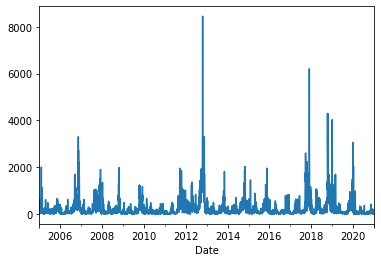

In [175]:
(np.exp(merge_df['Estimated_fire_area_WA']) - 1).plot()

In [255]:
submission_df

,Region,Date,Estimated_fire_area
0,NSW,Jan-16,1.534594
1,NSW,Jan-17,1.655527
2,NSW,Jan-18,0.000000
3,NSW,Jan-19,2.272245
4,NSW,Jan-20,1.941285
5,NSW,Jan-21,2.300243
6,NSW,Jan-22,2.037126
7,NT,Jan-16,1.930830
8,NT,Jan-17,1.711950
9,NT,Jan-18,2.067757


In [256]:
submission_df.to_csv('submissions/week3_dcnn2.csv', index= False, header=True)

In [335]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())

mse = mean_squared_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 38.90290729013289, 'mse': 22997.828797146867}}

In [349]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())

mse = mean_squared_error(y_true = yhat_df['2020-02':][fire_regions].values.flatten(),
                   y_pred = test['2020-02':][fire_regions].values.flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 37.61219740369566, 'mse': 23569.307062687083}}

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = (np.exp(yhat_df['2020-02':][fire_regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][fire_regions].values)-1).flatten())

mse = mean_squared_error(y_true = (np.exp(yhat_df['2020-02':][fire_regions].values)-1).flatten(),
                   y_pred = (np.exp(test['2020-02':][fire_regions].values)-1).flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 32.63632714983575, 'mse': 23245.925698827847}}

In [242]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
_results = {}


mae = mean_absolute_error(y_true = np.power(np.exp(yhat_df['2020-02':][sqrt_fire_regions].values)-1, 2).flatten(),
                   y_pred = np.power(np.exp(test['2020-02':][sqrt_fire_regions].values)-1, 2).flatten())

mse = mean_squared_error(y_true = np.power(np.exp(yhat_df['2020-02':][sqrt_fire_regions].values)-1, 2).flatten(),
                   y_pred = np.power(np.exp(test['2020-02':][sqrt_fire_regions].values)-1, 2).flatten())


_results['dcnn_log1p'] = {'mae': mae, 'mse': mse}
_results

{'dcnn_log1p': {'mae': 32.181879816855414, 'mse': 22984.509506718343}}

In [102]:
_results

{'dcnn_log1p': {'mae': 31.10491818762526, 'mse': 23585.2343689479}}

In [68]:
submission = np.exp(yhat_df['2020-02':'2020-02-28'][fire_regions])-1

In [350]:
submission = yhat_df['2020-02':'2020-02-28'][fire_regions]

In [351]:
submission

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA
Date,,,,,,,
2020-02-01,4.872530,16.290304,76.914148,19.893977,0.000000,23.908127,76.084201
2020-02-02,4.025656,23.735369,90.589854,23.487532,11.047121,16.285827,61.459896
2020-02-03,18.506602,51.645641,80.972067,24.013329,5.385706,21.382732,119.708074
2020-02-04,10.369689,48.859950,76.366904,0.000000,6.302943,28.132637,45.278764
2020-02-05,10.350995,17.703335,79.200445,10.995348,5.655730,24.478431,44.870076
2020-02-06,13.065515,50.335522,75.509145,8.041986,4.197926,28.485465,53.816033
2020-02-07,19.344893,0.677286,67.839734,8.646607,0.000000,21.937465,46.250313
2020-02-08,11.768787,48.010576,68.704283,14.024737,0.000000,16.893945,19.844584
2020-02-09,7.614478,0.000000,65.091977,0.000000,6.379442,22.420182,20.294774


In [352]:
submission = pd.melt(submission.reset_index(), id_vars = 'Date')

In [353]:
submission

,Date,variable,value
0,2020-02-01,Estimated_fire_area_NSW,4.872530
1,2020-02-02,Estimated_fire_area_NSW,4.025656
2,2020-02-03,Estimated_fire_area_NSW,18.506602
3,2020-02-04,Estimated_fire_area_NSW,10.369689
4,2020-02-05,Estimated_fire_area_NSW,10.350995
...,...,...,...
191,2020-02-24,Estimated_fire_area_WA,52.541951
192,2020-02-25,Estimated_fire_area_WA,52.417119
193,2020-02-26,Estimated_fire_area_WA,47.690596
194,2020-02-27,Estimated_fire_area_WA,49.066346


In [354]:
submission.rename(columns = {'variable': 'Region', 'value': 'Estimated_fire_area'}, inplace=True)
submission = pd.concat([submission[['Region']], submission[['Date']], submission['Estimated_fire_area']], axis = 1)

In [355]:
submission = pd.concat([submission[['Region']], submission[['Date']], submission['Estimated_fire_area']], axis = 1)

In [356]:
for i,x in zip(fire_regions, regions):
    submission['Region'].replace(to_replace = i, value = x, inplace=True)

In [357]:
submission

,Region,Date,Estimated_fire_area
0,NSW,2020-02-01,4.872530
1,NSW,2020-02-02,4.025656
2,NSW,2020-02-03,18.506602
3,NSW,2020-02-04,10.369689
4,NSW,2020-02-05,10.350995
...,...,...,...
191,WA,2020-02-24,52.541951
192,WA,2020-02-25,52.417119
193,WA,2020-02-26,47.690596
194,WA,2020-02-27,49.066346


In [358]:
submission.to_csv('Phase_1_sqrt_log4.csv', index= False,header=True)